### Gerando os dados, dividindo em Treino, validação e teste, além de transformar em tensores.

In [ ]:
# -*- coding: utf-8 -*-
"""
Criação dos dados e ajuste (normalização) para MLP
Funções:
  (a) f(x) = sin(2x) + cos(3x),  domínio padrão: [0, 5]
  (b) f(x) = 10x^5 + 5x^4 + 2x^3 - 0.5x^2 + 3x + 2, domínio padrão: [0, 1]

Saída:
  - train_dl, val_dl, test_dl para cada função (DataLoaders prontos)
  - stats com médias/desvios para reverter normalização na inferência/plot
"""

import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader

# -----------------------------
# 1) Definição das funções alvo
# -----------------------------
def f_a(x):
    # x: array (N, 1)
    return np.sin(2.0 * x) + np.cos(3.0 * x)

def f_b(x):
    return 10.0*(x**5) + 5.0*(x**4) + 2.0*(x**3) - 0.5*(x**2) + 3.0*x + 2.0

# -------------------------------------
# 2) Geração e embaralhamento dos dados
# -------------------------------------
def make_dataset(func, domain, n_total, seed=42):
    """
    Gera x ~ Uniform(domain[0], domain[1]) e y = func(x).
    Retorna x, y como float32 com shape (N, 1).
    """
    rng = np.random.default_rng(seed)
    x = rng.uniform(domain[0], domain[1], size=(n_total, 1)).astype(np.float32)
    y = func(x).astype(np.float32)
    # embaralha de forma consistente
    idx = rng.permutation(n_total)
    return x[idx], y[idx]

# ------------------------------------------
# 3) Split + normalização (x e, opcional, y)
# ------------------------------------------
def split_and_normalize(x, y, n_train=1024, n_val=256, n_test=256, normalize_y=True):
    """
    Divide em (train/val/test) e normaliza:
      x_norm = (x - mean_x_train)/std_x_train
      y_norm = (y - mean_y_train)/std_y_train (se normalize_y=True)
    Retorna tensores numpy normalizados + dicionário com stats.
    """
    assert len(x) >= (n_train + n_val + n_test), "Amostras insuficientes."

    x_train, y_train = x[:n_train], y[:n_train]
    x_val,   y_val   = x[n_train:n_train+n_val], y[n_train:n_train+n_val]
    x_test,  y_test  = x[n_train+n_val:n_train+n_val+n_test], y[n_train+n_val:n_train+n_val+n_test]

    # estatísticas do treino
    x_mean = x_train.mean(axis=0, keepdims=True)
    x_std  = x_train.std(axis=0, keepdims=True) + 1e-8

    x_train_n = (x_train - x_mean) / x_std
    x_val_n   = (x_val   - x_mean) / x_std
    x_test_n  = (x_test  - x_mean) / x_std

    if normalize_y:
        y_mean = y_train.mean(axis=0, keepdims=True)
        y_std  = y_train.std(axis=0, keepdims=True) + 1e-8
        y_train_n = (y_train - y_mean) / y_std
        y_val_n   = (y_val   - y_mean) / y_std
        y_test_n  = (y_test  - y_mean) / y_std
    else:
        y_mean = np.zeros_like(y[:1])
        y_std  = np.ones_like(y[:1])
        y_train_n, y_val_n, y_test_n = y_train, y_val, y_test

    stats = {
        "x_mean": x_mean, "x_std": x_std,
        "y_mean": y_mean, "y_std": y_std,
        "normalize_y": normalize_y
    }
    return (x_train_n, y_train_n,
            x_val_n,   y_val_n,
            x_test_n,  y_test_n,
            stats)

# ---------------------------------
# 4) DataLoaders prontos para MLP
# ---------------------------------
def make_loaders(x_train, y_train, x_val, y_val, x_test, y_test, batch_size=128):
    """
    Converte numpy -> torch.Tensor e empacota em DataLoaders.
    """
    train_ds = TensorDataset(torch.from_numpy(x_train), torch.from_numpy(y_train))
    val_ds   = TensorDataset(torch.from_numpy(x_val),   torch.from_numpy(y_val))
    test_ds  = TensorDataset(torch.from_numpy(x_test),  torch.from_numpy(y_test))

    train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_dl   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False)
    test_dl  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False)
    return train_dl, val_dl, test_dl

# ---------------------------------
# 5) Exemplo de uso (a) e (b)
# ---------------------------------
if __name__ == "__main__":
    
    DOMAIN_A = (0.0, 5.0)  # f_a
    DOMAIN_B = (0.0, 5.0)  # f_b 

    # tamanhos
    N_TRAIN, N_VAL, N_TEST = 1024, 256, 256
    N_TOTAL = N_TRAIN + N_VAL + N_TEST

    # --- Função (a) ---
    xa, ya = make_dataset(f_a, DOMAIN_A, N_TOTAL, seed=1)
    xa_tr, ya_tr, xa_va, ya_va, xa_te, ya_te, stats_a = split_and_normalize(
        xa, ya, n_train=N_TRAIN, n_val=N_VAL, n_test=N_TEST, normalize_y=True
    )
    train_a, val_a, test_a = make_loaders(xa_tr, ya_tr, xa_va, ya_va, xa_te, ya_te, batch_size=128)

    # --- Função (b) ---
    xb, yb = make_dataset(f_b, DOMAIN_B, N_TOTAL, seed=2)
    xb_tr, yb_tr, xb_va, yb_va, xb_te, yb_te, stats_b = split_and_normalize(
        xb, yb, n_train=N_TRAIN, n_val=N_VAL, n_test=N_TEST, normalize_y=True
    )
    train_b, val_b, test_b = make_loaders(xb_tr, yb_tr, xb_va, yb_va, xb_te, yb_te, batch_size=128)

    # Inspeção rápida:
    print("Função (a):")
    print("  x_train shape:", xa_tr.shape, "| y_train shape:", ya_tr.shape)
    print("  x_validation shape:", xa_va.shape, "| y_validation shape:", ya_va.shape)
    print("  x_test shape:", xa_te.shape, "| y_test shape:", ya_te.shape)
    print("  x_mean/std:", stats_a["x_mean"].ravel(), stats_a["x_std"].ravel())
    print("  y_mean/std:", stats_a["y_mean"].ravel(), stats_a["y_std"].ravel())

    print("\nFunção (b):")
    print("  x_train shape:", xb_tr.shape, "| y_train shape:", yb_tr.shape)
    print("  x_validation shape:", xb_va.shape, "| y_validation shape:", yb_va.shape)
    print("  x_test shape:", xb_te.shape, "| y_test shape:", yb_te.shape)
    print("  x_validation shape:", xb_va.shape, "| y_validation shape:", yb_va.shape)
    print("  x_mean/std:", stats_b["x_mean"].ravel(), stats_b["x_std"].ravel())
    print("  y_mean/std:", stats_b["y_mean"].ravel(), stats_b["y_std"].ravel())



Função (a):
  x_train shape: (1024, 1) | y_train shape: (1024, 1)
  x_validation shape: (256, 1) | y_validation shape: (256, 1)
  x_test shape: (256, 1) | y_test shape: (256, 1)
  x_mean/std: [2.494779] [1.4463867]
  y_mean/std: [0.23734441] [0.87528676]

Função (b):
  x_train shape: (1024, 1) | y_train shape: (1024, 1)
  x_validation shape: (256, 1) | y_validation shape: (256, 1)
  x_test shape: (256, 1) | y_test shape: (256, 1)
  x_validation shape: (256, 1) | y_validation shape: (256, 1)
  x_mean/std: [2.5395248] [1.4613246]
  y_mean/std: [6239.597] [8975.806]


### MLP e plots

device: cpu
epoch 001 | train=1.575768 | val=1.090462
epoch 025 | train=0.551474 | val=0.521749
epoch 050 | train=0.361977 | val=0.326201
epoch 075 | train=0.122708 | val=0.110008
epoch 100 | train=0.020426 | val=0.023546
epoch 125 | train=0.007857 | val=0.013765
epoch 150 | train=0.006576 | val=0.010768
[função (a)] melhor val=0.009759 | test MSE=0.004228
epoch 001 | train=0.267115 | val=0.229244
epoch 025 | train=0.015310 | val=0.012406
epoch 050 | train=0.002881 | val=0.002303
epoch 075 | train=0.001129 | val=0.000779
epoch 100 | train=0.000578 | val=0.000377
[função (b)] melhor val=0.000377 | test MSE=0.000688


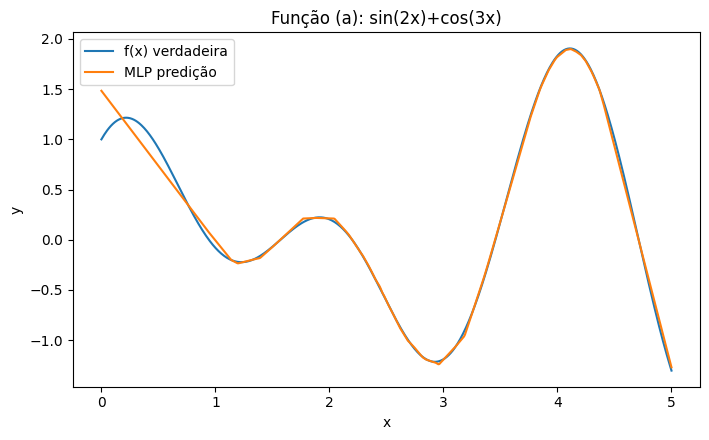

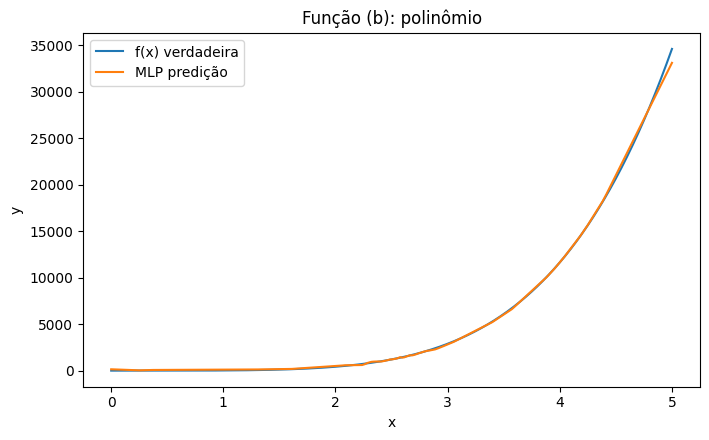

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", DEVICE)

# -------------------------------------------------------
# 1) Modelo: camadas densas + ReLU (simples e eficiente)
# -------------------------------------------------------
class MLP(nn.Module):
    def __init__(self, in_dim=1, hidden=(64, 64), out_dim=1):
        super().__init__()
        layers = []
        last = in_dim
        for h in hidden:
            layers += [nn.Linear(last, h), nn.ReLU(inplace=True)]
            last = h
        layers += [nn.Linear(last, out_dim)]  # saída linear (regressão)
        self.net = nn.Sequential(*layers)
        self.apply(self._init)

    @staticmethod
    def _init(m):
        # He/Kaiming para ReLU
        if isinstance(m, nn.Linear):
            nn.init.kaiming_normal_(m.weight, nonlinearity="relu")
            if m.bias is not None:
                nn.init.zeros_(m.bias)

    def forward(self, x):
        return self.net(x)


# -------------------------------------------------------
# 2) Funções de treino/val e avaliação simples (MSE)
# -------------------------------------------------------
def train_one_epoch(model, loader, opt, criterion):
    model.train()
    total, n = 0.0, 0
    for xb, yb in loader:
        xb = xb.to(DEVICE).float()
        yb = yb.to(DEVICE).float()
        opt.zero_grad()
        pred = model(xb)
        loss = criterion(pred, yb)
        loss.backward()
        opt.step()
        total += loss.item() * xb.size(0)
        n += xb.size(0)
    return total / n

@torch.no_grad()
def evaluate(model, loader, criterion):
    model.eval()
    total, n = 0.0, 0
    for xb, yb in loader:
        xb = xb.to(DEVICE).float()
        yb = yb.to(DEVICE).float()
        pred = model(xb)
        loss = criterion(pred, yb)
        total += loss.item() * xb.size(0)
        n += xb.size(0)
    return total / n

# -------------------------------------------------------
# 3) Loop de treino com early stopping simples (paciência)
# -------------------------------------------------------
def fit(model, train_dl, val_dl, epochs=400, lr=1e-3, weight_decay=1e-5, patience=30):
    model = model.to(DEVICE)
    opt = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = nn.MSELoss()

    best_val = float("inf")
    best_state = None
    wait = 0

    for ep in range(1, epochs+1):
        tr = train_one_epoch(model, train_dl, opt, criterion)
        va = evaluate(model, val_dl, criterion)

        if va < best_val - 1e-7:
            best_val = va
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
            wait = 0
        else:
            wait += 1
            if wait >= patience:
                print(f"[ES] parada na época {ep} | melhor val={best_val:.6f}")
                break

        if ep == 1 or ep % 25 == 0:
            print(f"epoch {ep:03d} | train={tr:.6f} | val={va:.6f}")

    if best_state is not None:
        model.load_state_dict(best_state)
    return model, best_val

@torch.no_grad()
def test_mse(model, test_dl):
    return evaluate(model, test_dl, nn.MSELoss())


# -------------------------------------------------------
# 4) EXEMPLOS — usando seus DataLoaders prontos
# -------------------------------------------------------
# Dica: ajuste 'hidden' se under/overfitting (ex.: (128,128) ou (128,64,64))
mlp_a = MLP(in_dim=1, hidden=(64, 64), out_dim=1)
mlp_a, best_val_a = fit(mlp_a, train_a, val_a, epochs=150, lr=1e-3, weight_decay=1e-5, patience=40)
mse_test_a = test_mse(mlp_a, test_a)
print(f"[função (a)] melhor val={best_val_a:.6f} | test MSE={mse_test_a:.6f}")

mlp_b = MLP(in_dim=1, hidden=(64, 64), out_dim=1)
mlp_b, best_val_b = fit(mlp_b, train_b, val_b, epochs=100, lr=1e-3, weight_decay=1e-5, patience=40)
mse_test_b = test_mse(mlp_b, test_b)
print(f"[função (b)] melhor val={best_val_b:.6f} | test MSE={mse_test_b:.6f}")

# -------------------------------------------------------
# 5)Plot
# -------------------------------------------------------
def predict_curve(model, x_grid, stats):
    # normaliza x_grid com stats do treino
    xg = (x_grid - stats["x_mean"]) / stats["x_std"]
    with torch.no_grad():
        pred = model(torch.from_numpy(xg.astype(np.float32)).to(DEVICE)).cpu().numpy()
    # desnormaliza y, se aplicável
    if stats["normalize_y"]:
        pred = pred * stats["y_std"] + stats["y_mean"]
    return pred

def quick_plot(model, stats, func, domain, title):
    xg = np.linspace(domain[0], domain[1], 600).reshape(-1,1).astype(np.float32)
    y_true = func(xg).astype(np.float32)
    y_pred = predict_curve(model, xg, stats)
    plt.figure(figsize=(7.2, 4.5))
    plt.title(title)
    plt.plot(xg, y_true, label="f(x) verdadeira")
    plt.plot(xg, y_pred, label="MLP predição")
    plt.xlabel("x"); plt.ylabel("y"); plt.legend(); plt.tight_layout()
    plt.show()

# Se você tem as funções e domínios definidos na etapa de dados:
#   f_a, f_b, DOMAIN_A, DOMAIN_B, stats_a, stats_b
try:
    quick_plot(mlp_a, stats_a, f_a, DOMAIN_A, "Função (a): sin(2x)+cos(3x)")
    quick_plot(mlp_b, stats_b, f_b, DOMAIN_B, "Função (b): ")
except NameError:
    print("Pulei os plots porque variáveis (f_a/f_b/DOMAIN_*/stats_*) não estão no escopo.")
